# Deep learning for Bulldozers

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.torch_imports import *
from fastai.dataset import *
from fastai.learner import *
from fastai.structured import *
from fastai.column_data import *

# Load in our data from last lesson

In [3]:
dep = 'SalePrice' # dependency variable
PATH = "data/bulldozers/"
#df_raw = pd.read_feather('tmp/raw')
df_raw = pd.read_feather('tmp/bulldozers-raw')
keep_cols = list(np.load('tmp/keep_cols.npy'))

In [4]:
df_raw.loc[df_raw.YearMade<1950, 'YearMade'] = 1950 # set YearMade to 1950 when YearMade is smaller than 1950
df_raw['age'] = df_raw.saleYear-df_raw.YearMade
df_raw = df_raw[keep_cols+['age', dep]].copy()
df_indep = df_raw.drop(dep,axis=1)

n_valid = 12000
n_trn = len(df_raw)-n_valid

In [5]:
cat_flds = [n for n in df_indep.columns if df_raw[n].nunique()<n_trn/50]
' '.join(cat_flds)

'YearMade Coupler_System ProductSize fiProductClassDesc ModelID saleElapsed Hydraulics_Flow fiSecondaryDesc Enclosure fiModelDesc fiModelDescriptor Hydraulics ProductGroup ProductGroupDesc Tire_Size state saleDay saleDayofyear Track_Type Drive_System age'

In [6]:
# Remove ['saleElapsed', 'saleDayofyear', 'saleDay', 'age', 'YearMade'] from cat_flds
for o in ['saleElapsed', 'saleDayofyear', 'saleDay', 'age', 'YearMade']: cat_flds.remove(o) 
[n for n in df_indep.drop(cat_flds,axis=1).columns if not is_numeric_dtype(df_raw[n])]

[]

In [7]:
for n in cat_flds: df_raw[n] = df_raw[n].astype('category').cat.as_ordered() # Set 'category' type

cont_flds = [n for n in df_indep.columns if n not in cat_flds] # other fields are cont_flds
' '.join(cont_flds)

'YearMade saleElapsed SalesID MachineID saleDay saleDayofyear age'

In [9]:
df_raw = df_raw[cat_flds+cont_flds+[dep]]
# df, y, mapper = proc_df(df_raw, 'SalePrice', do_scale=True)
df, y, _nas, mapper = proc_df(df_raw, 'SalePrice', do_scale=True)

val_idx = list(range(n_trn, len(df)))

In [10]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y, cat_flds=cat_flds, bs=64)

In [12]:
df.head()

,Coupler_System,ProductSize,fiProductClassDesc,ModelID,Hydraulics_Flow,fiSecondaryDesc,Enclosure,fiModelDesc,fiModelDescriptor,Hydraulics,...,state,Track_Type,Drive_System,YearMade,saleElapsed,SalesID,MachineID,saleDay,saleDayofyear,age
0,0,0,59,644,0,41,3,950,0,1,...,1,0,0,0.913196,0.397377,-0.858580,-0.496185,-0.013101,1.352092,-0.828814
1,0,4,62,11,0,55,3,1725,0,1,...,33,0,0,0.405756,-0.061496,-0.858578,-2.494936,1.173518,-0.907472,-0.430749
2,1,0,39,1542,3,0,6,331,0,4,...,32,0,0,0.722906,-0.075286,-0.858577,-1.775759,1.173518,-1.187503,-0.762470
3,0,6,8,110,0,0,3,3674,0,1,...,44,0,0,0.722906,1.179600,-0.858574,-0.434096,0.342885,-0.395690,-0.298060
4,1,0,40,3540,3,0,1,4208,0,4,...,32,0,0,1.103486,0.863382,-0.858572,-0.364020,0.817532,0.231967,-0.828814


# Model

In [13]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

In [14]:
# Calculate embedding size
emb_c = {n: len(c.cat.categories)+1 for n,c in df_raw[cat_flds].items()}
emb_c

{'Coupler_System': 3,
 'Drive_System': 5,
 'Enclosure': 7,
 'Hydraulics': 13,
 'Hydraulics_Flow': 4,
 'ModelID': 5219,
 'ProductGroup': 7,
 'ProductGroupDesc': 7,
 'ProductSize': 7,
 'Tire_Size': 18,
 'Track_Type': 3,
 'fiModelDesc': 5000,
 'fiModelDescriptor': 140,
 'fiProductClassDesc': 75,
 'fiSecondaryDesc': 176,
 'state': 54}

In [15]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in emb_c.items()]
metrics=[rmse]

In [16]:
y_range=(0,np.max(y)*1.2)

In [17]:
m = md.get_learner(emb_szs, len(cont_flds), 0.05, 1, [500,250], [0.5,0.05],
                   y_range=y_range, use_bn=True)

In [18]:
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(7, 4)
    (2): Embedding(75, 38)
    (3): Embedding(5219, 50)
    (4): Embedding(4, 2)
    (5): Embedding(176, 50)
    (6): Embedding(7, 4)
    (7): Embedding(5000, 50)
    (8): Embedding(140, 50)
    (9): Embedding(13, 7)
    (10): Embedding(7, 4)
    (11): Embedding(7, 4)
    (12): Embedding(18, 9)
    (13): Embedding(54, 27)
    (14): Embedding(3, 2)
    (15): Embedding(5, 3)
  )
  (lins): ModuleList(
    (0): Linear(in_features=313, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=250, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=250, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.05)
  (drops): ModuleList(
    (0): Dropout(p=0.5)
    (1): Dropout(p=0.05)
  )
  (bn): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True)


In [19]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 60%|██████    | 3667/6081 [01:50<01:12, 33.33it/s, loss=0.364] 

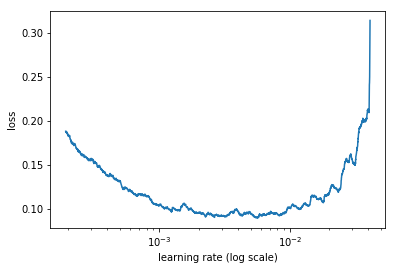

In [20]:
m.sched.plot(1300)

In [21]:
lr=1e-3; wd=1e-7

In [22]:
m.fit(lr, 2, wd, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  2%|▏         | 114/6081 [00:02<02:14, 44.50it/s, loss=9.08]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/tsuyoshi/anaconda3/envs/fastai-cpu/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/tsuyoshi/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/tsuyoshi/anaconda3/envs/fastai-cpu/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                  
    0      0.062862   0.112279  
    1      0.059326   0.073036                                  
    2      0.053488   0.084489                                  



[0.08448918]

In [23]:
m.fit(lr, 2, wd, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.056134   0.100128  
    1      0.050738   0.0861                                    
    2      0.05546    0.064745                                  
    3      0.050806   0.061799                                  
    4      0.046855   0.068507                                  
    5      0.043143   0.070691                                  



[0.07069147]

In [24]:
math.sqrt(0.0487)

0.22068076490713912